In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [35]:
df = pd.read_csv('heart_disease.csv')

In [36]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,45.0,F,ASY,120.0,263.0,0.0,Normal,159.0,N,0.0,Up,0
1,58.0,M,ASY,116.0,239.0,0.0,LVH,154.0,Y,1.0,Flat,1
2,61.0,F,ATA,130.0,192.0,0.0,Normal,133.0,N,1.0,Flat,0
3,64.0,M,ASY,167.0,209.0,1.0,Normal,108.0,Y,3.0,Down,1
4,50.0,M,ASY,141.0,0.0,1.0,ST,157.0,N,0.0,Flat,1
5,56.0,M,ATA,116.0,263.0,0.0,Normal,138.0,N,0.0,Up,1
6,64.0,M,ASY,111.0,0.0,0.0,Normal,89.0,Y,0.0,Flat,1
7,57.0,M,NAP,163.0,0.0,0.0,Normal,76.0,Y,0.0,Flat,1
8,56.0,M,ASY,150.0,171.0,0.0,LVH,112.0,Y,3.0,Down,1
9,56.0,M,ASY,171.0,266.0,0.0,Normal,79.0,N,2.0,Flat,1


In [37]:
num_instances = len(df)
print(f"Number of instances in the DataFrame: {num_instances}")

Number of instances in the DataFrame: 15000


In [38]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,54.30920,133.075467,191.091867,0.271933,133.880133,1.030467,0.700000
std,9.63541,19.852551,117.057733,0.444971,25.911356,1.113802,0.458273
min,25.00000,0.000000,0.000000,0.000000,55.000000,0.000000,0.000000
25%,48.00000,120.000000,152.000000,0.000000,116.000000,0.000000,0.000000
50%,55.00000,131.000000,220.000000,0.000000,132.000000,1.000000,1.000000
75%,61.00000,144.000000,267.000000,1.000000,152.000000,2.000000,1.000000
max,83.00000,225.000000,653.000000,1.000000,221.000000,7.000000,1.000000


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             15000 non-null  float64
 1   Sex             15000 non-null  object 
 2   ChestPainType   15000 non-null  object 
 3   RestingBP       15000 non-null  float64
 4   Cholesterol     15000 non-null  float64
 5   FastingBS       15000 non-null  float64
 6   RestingECG      15000 non-null  object 
 7   MaxHR           15000 non-null  float64
 8   ExerciseAngina  15000 non-null  object 
 9   Oldpeak         15000 non-null  float64
 10  ST_Slope        15000 non-null  object 
 11  HeartDisease    15000 non-null  int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 1.4+ MB


In [40]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [41]:
df.dropna(inplace=True)

In [42]:
df.duplicated().sum()

np.int64(9)

In [43]:
df.drop_duplicates(inplace=True)

In [44]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [45]:
df.duplicated().sum()

np.int64(0)

In [46]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
target_col = 'HeartDisease'
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

Age outliers: 39
RestingBP outliers: 311
Cholesterol outliers: 138
FastingBS outliers: 0
MaxHR outliers: 32
Oldpeak outliers: 40


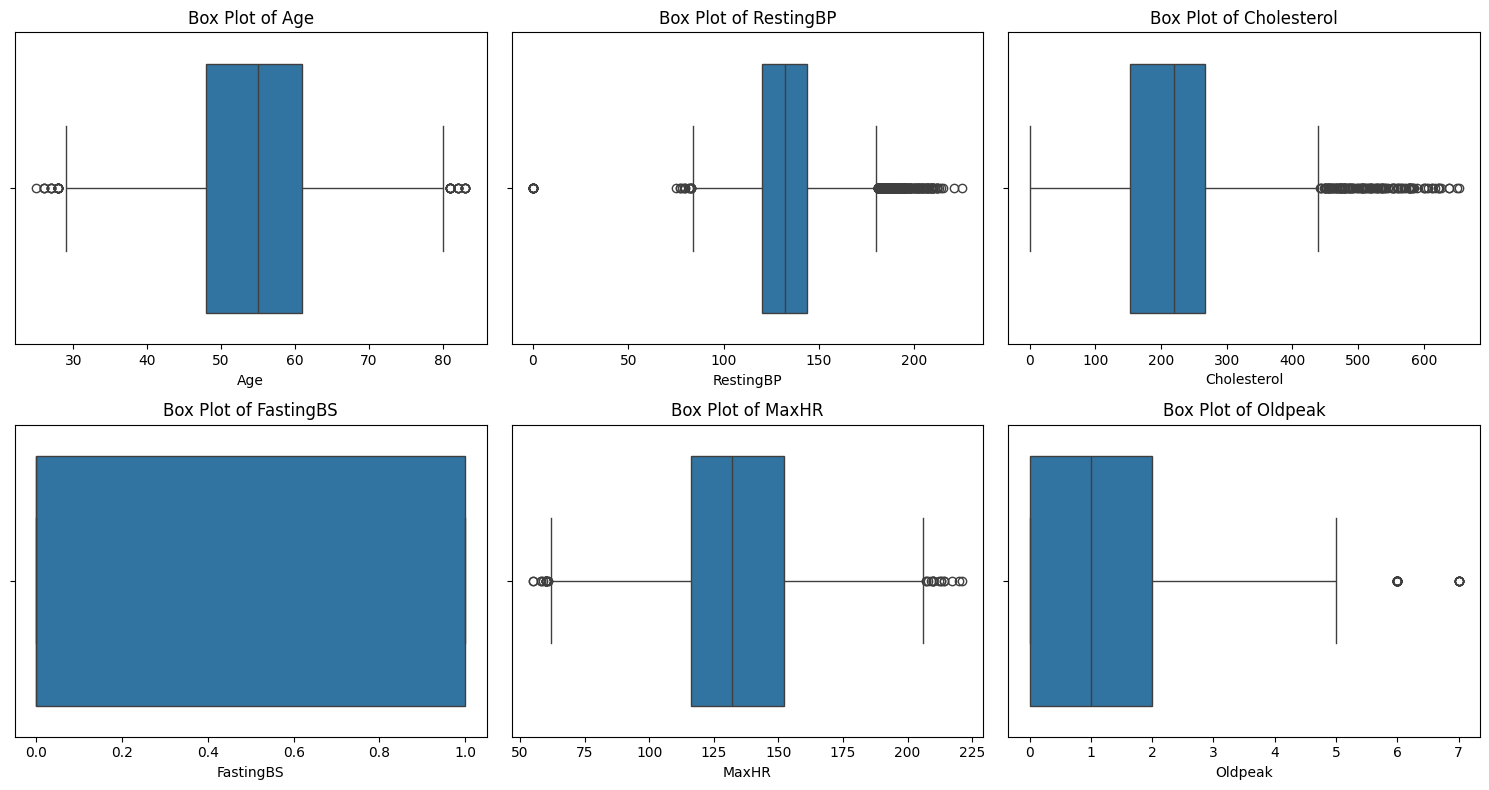

In [47]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)]

# Print outlier counts per numerical column
for col in numerical_cols:
    count = detect_outliers_iqr(df, col).shape[0]
    print(f"{col} outliers: {count}")

# Display box plots for numerical columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, (len(numerical_cols)+1)//2, i)  # Arrange plots in 2 rows
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()



Shape of DataFrame after outlier removal: (14426, 12)

Outliers count after removal:
Age outliers: 0
RestingBP outliers: 0
Cholesterol outliers: 0
FastingBS outliers: 0
MaxHR outliers: 0
Oldpeak outliers: 0


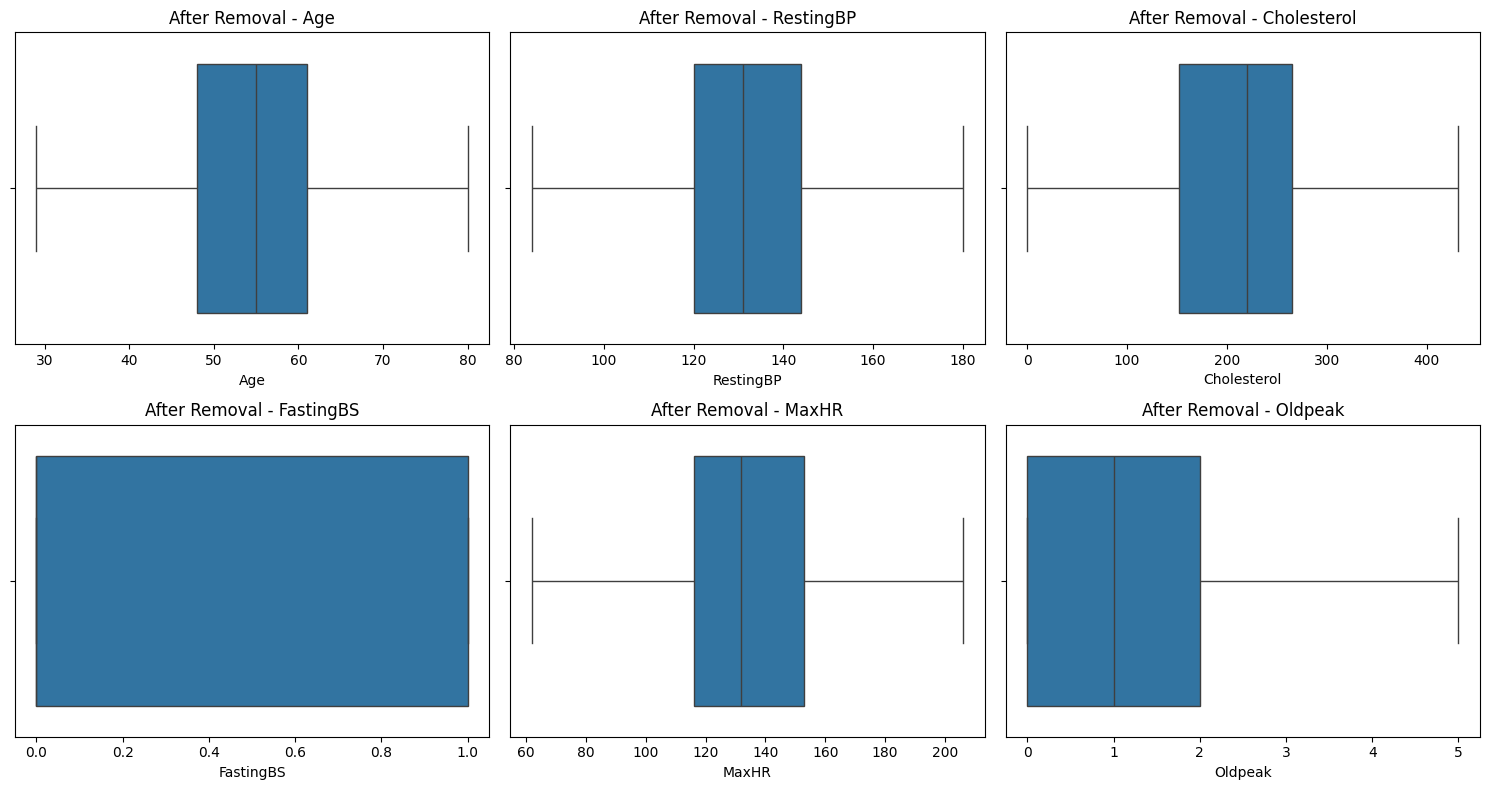

In [48]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"\nShape of DataFrame after outlier removal: {df.shape}")

# Print outlier counts after removal (should be zero or near zero)
print("\nOutliers count after removal:")
for col in numerical_cols:
    count = detect_outliers_iqr(df, col).shape[0]
    print(f"{col} outliers: {count}")

# Show box plots after removal
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, (len(numerical_cols)+1)//2, i)
    sns.boxplot(x=df[col])
    plt.title(f'After Removal - {col}')
plt.tight_layout()
plt.show()

In [49]:
ordinal_mappings = { 'ST_Slope': ['Up', 'Flat', 'Down'] }
label_encoders = {}

for col in categorical_cols:
    if col in ordinal_mappings:
        df[[col]] = OrdinalEncoder(categories=[ordinal_mappings[col]]).fit_transform(df[[col]])
    else:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

In [50]:
X = df.drop(target_col, axis=1)
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [51]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test.index)

X_train_processed = pd.concat([X_train_scaled_df, X_train[categorical_cols]], axis=1)
X_test_processed = pd.concat([X_test_scaled_df, X_test[categorical_cols]], axis=1)

Class distribution before SMOTE:
HeartDisease
1    7036
0    3062
Name: count, dtype: int64


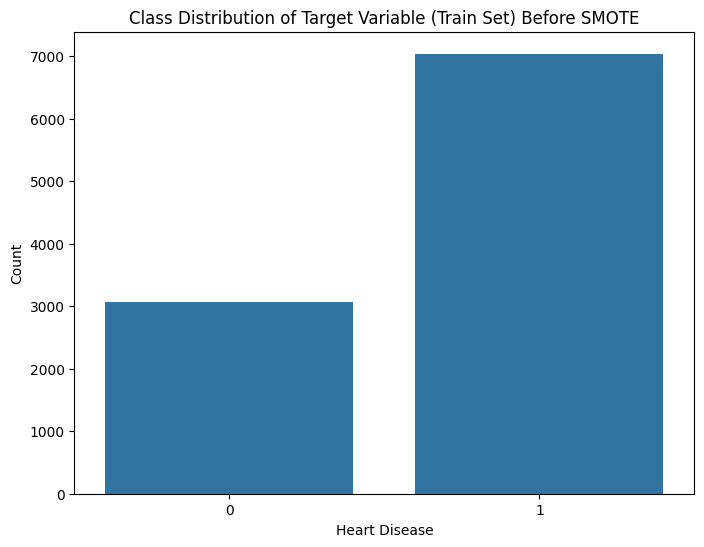

In [52]:
# Check class balance of the target variable
print("Class distribution before SMOTE:")
print(y_train.value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution of Target Variable (Train Set) Before SMOTE')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

Before SMOTE: HeartDisease
1    7036
0    3062
Name: count, dtype: int64
After SMOTE: HeartDisease
1    7036
0    7036
Name: count, dtype: int64


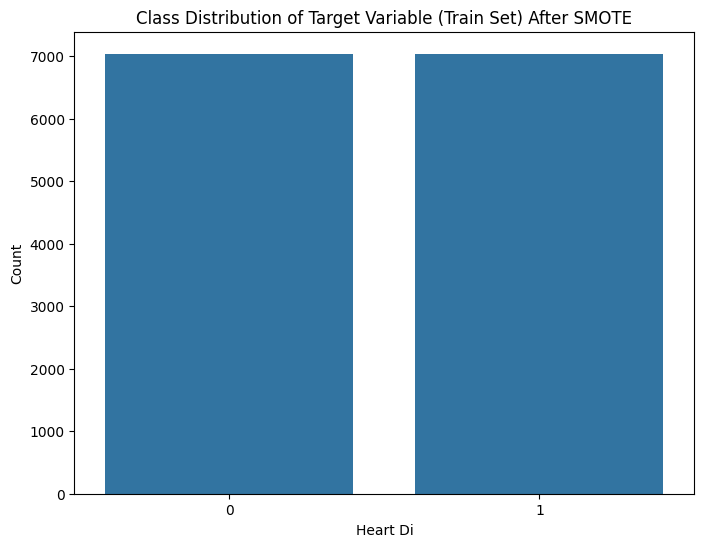

In [53]:
print("Before SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("After SMOTE:", y_train_resampled.value_counts())

# Plot the class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution of Target Variable (Train Set) After SMOTE')
plt.xlabel('Heart Di')
plt.ylabel('Count')
plt.show()

Class distribution before applying other imbalance techniques:
HeartDisease
1    7036
0    3062
Name: count, dtype: int64


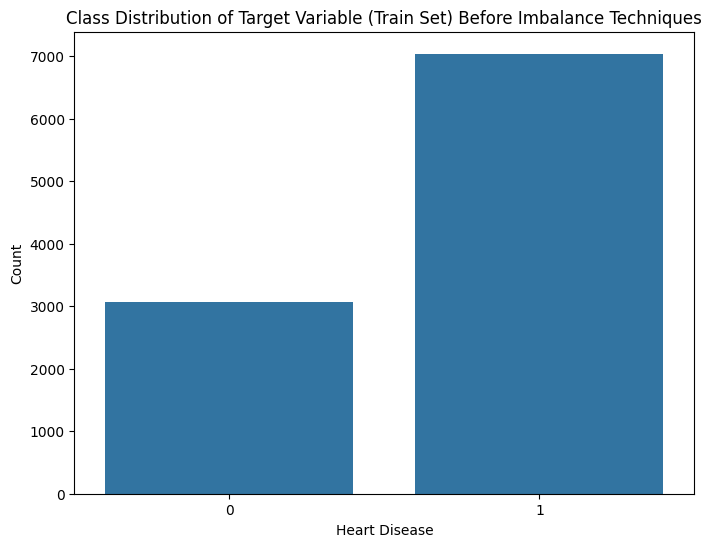

In [54]:
from imblearn.over_sampling import ADASYN

# Check class balance again before applying new techniques
print("Class distribution before applying other imbalance techniques:")
print(y_train.value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution of Target Variable (Train Set) Before Imbalance Techniques')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()


--- Applying ADASYN ---
After ADASYN: HeartDisease
1    7036
0    6987
Name: count, dtype: int64


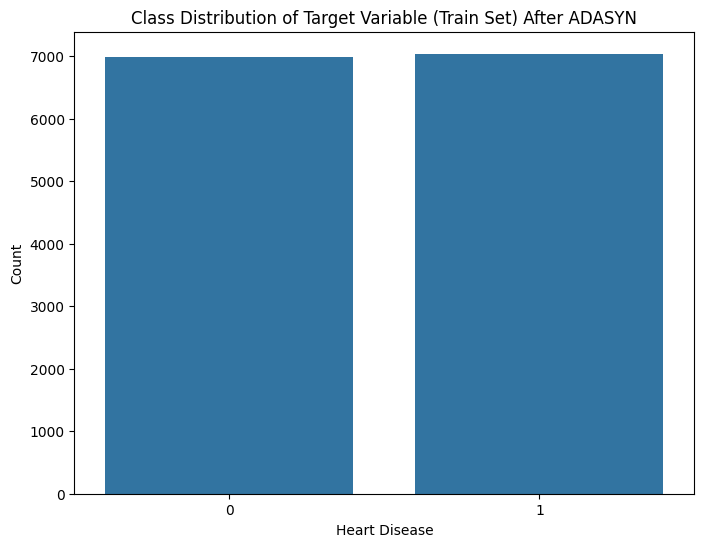

In [55]:
print("\n--- Applying ADASYN ---")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_processed, y_train)

print("After ADASYN:", y_train_adasyn.value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_adasyn)
plt.title('Class Distribution of Target Variable (Train Set) After ADASYN')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()


Best silhouette score 0.5502 with 2 PCA components.
Optimal k based on silhouette: 4

--- Clustering Metrics ---
KMeans Silhouette: 0.6580
Agglomerative Silhouette: 0.6582
KMeans DB Index: 0.4330
Agglomerative DB Index: 0.4224


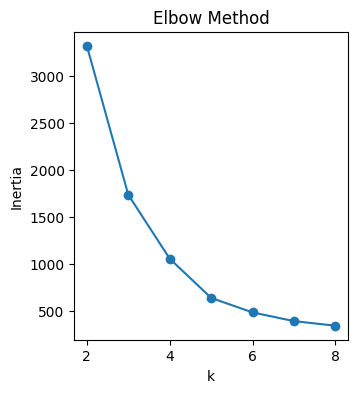

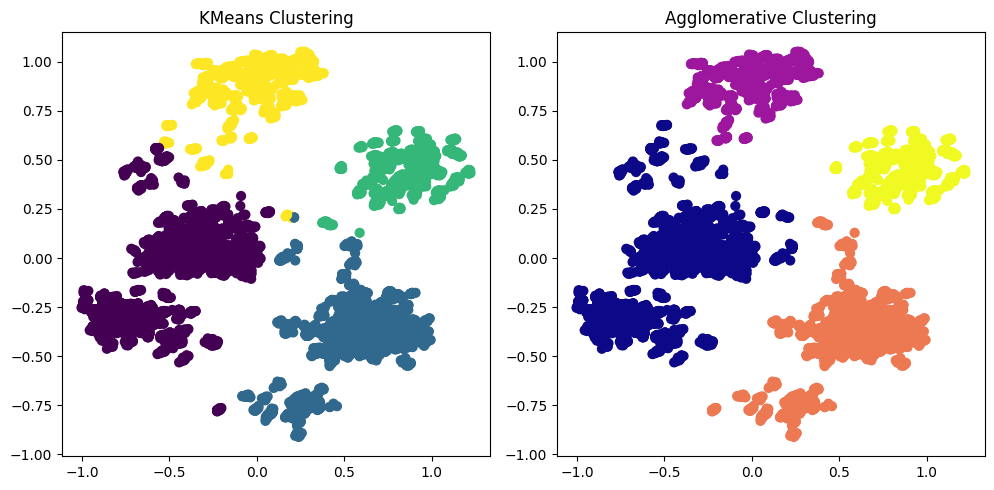

In [56]:
# 1. Preprocessing: Handle missing values and scale
X_clustering = X_train_resampled.copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clustering)

# 2. Determine optimal PCA components using silhouette score
best_silhouette = -1
best_n = 2
silhouette_scores = []
max_pca = min(10, X_scaled.shape[1])

for n in range(2, max_pca + 1):  # start from 2 for meaningful clustering
    pca = PCA(n_components=n, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, clusters)
    silhouette_scores.append(sil)
    if sil > best_silhouette:
        best_silhouette = sil
        best_n = n


print(f"Best silhouette score {best_silhouette:.4f} with {best_n} PCA components.")

# 3. Apply best PCA
pca = PCA(n_components=best_n, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 4. Elbow Method & Silhouette for Optimal k
inertia = []
silhouettes = []
max_k = 8
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    preds = kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_pca, preds))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

# 5. Choose best k
k_optimal = np.argmax(silhouettes) + 2  # offset because k starts from 2
print(f"Optimal k based on silhouette: {k_optimal}")

# 6. Clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=20)
kmeans_clusters = kmeans.fit_predict(X_pca)

agg = AgglomerativeClustering(n_clusters=k_optimal, linkage='ward')
agg_clusters = agg.fit_predict(X_pca)

# 7. (Optional: Add cluster summary/statistics here)

# 8. Validation
print("\n--- Clustering Metrics ---")
print(f"KMeans Silhouette: {silhouette_score(X_pca, kmeans_clusters):.4f}")
print(f"Agglomerative Silhouette: {silhouette_score(X_pca, agg_clusters):.4f}")
print(f"KMeans DB Index: {davies_bouldin_score(X_pca, kmeans_clusters):.4f}")
print(f"Agglomerative DB Index: {davies_bouldin_score(X_pca, agg_clusters):.4f}")

# 9. Visualization
pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(X_scaled)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=kmeans_clusters, cmap='viridis', s=40)
plt.title("KMeans Clustering")

plt.subplot(1, 3, 2)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=agg_clusters, cmap='plasma', s=40)
plt.title("Agglomerative Clustering")

plt.tight_layout()
plt.show()



--- Univariate Feature Selection (SelectKBest) ---
Top 8 features selected by SelectKBest (f_classif):
['Age', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope']

Feature Scores (SelectKBest - f_classif):
ST_Slope          6538.665738
ExerciseAngina    4829.089930
Oldpeak           3041.909367
MaxHR             3010.053985
ChestPainType     2514.281238
Sex               1523.155898
FastingBS         1166.556085
Age               1004.066120
Cholesterol       1001.046558
RestingBP           97.442928
RestingECG          36.898881
dtype: float64


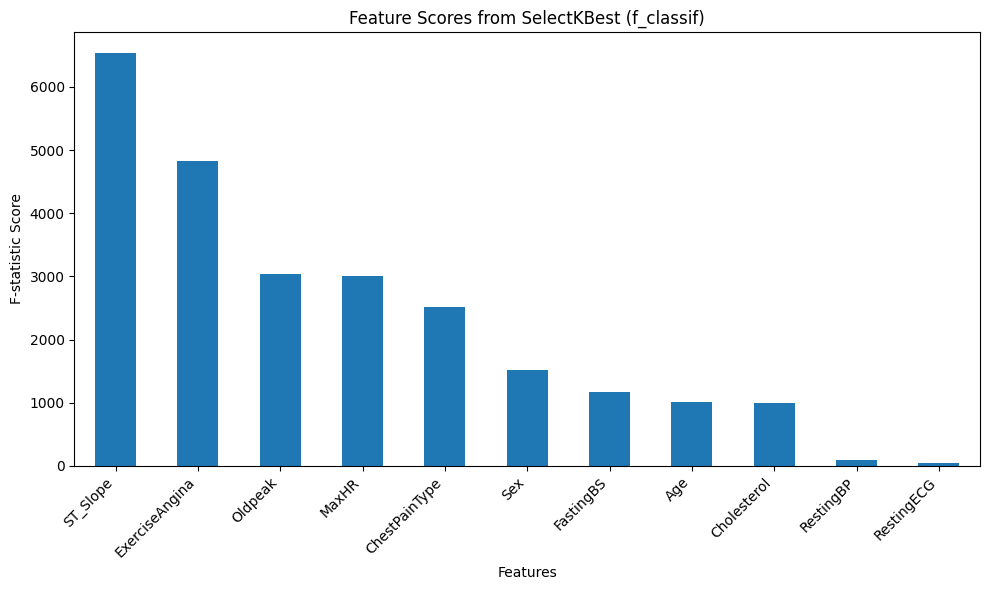

In [57]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
print("\n--- Univariate Feature Selection (SelectKBest) ---")

# Select top k features (e.g., k=5)
k_features = 8
selector_kbest = SelectKBest(score_func=f_classif, k=k_features) # Using f_classif

# Fit on the processed training data
selector_kbest.fit(X_train_resampled, y_train_resampled)

# Get the indices of the selected features
selected_features_kbest_indices = selector_kbest.get_support(indices=True)

# Get the names of the selected features
selected_features_kbest_names = X_train_resampled.columns[selected_features_kbest_indices]

print(f"Top {k_features} features selected by SelectKBest (f_classif):")
print(selected_features_kbest_names.tolist())

# Get the scores of the features
feature_scores_kbest = pd.Series(selector_kbest.scores_, index=X_train_resampled.columns)
feature_scores_kbest_sorted = feature_scores_kbest.sort_values(ascending=False)

print("\nFeature Scores (SelectKBest - f_classif):")
print(feature_scores_kbest_sorted)

# Visualize feature scores
plt.figure(figsize=(10, 6))
feature_scores_kbest_sorted.plot(kind='bar')
plt.title('Feature Scores from SelectKBest (f_classif)')
plt.ylabel('F-statistic Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



--- Model-based Feature Selection (RandomForestClassifier) ---

Feature Importances (RandomForestClassifier):
ST_Slope          0.248261
ChestPainType     0.151446
Cholesterol       0.113999
MaxHR             0.090049
ExerciseAngina    0.080950
Oldpeak           0.077719
RestingBP         0.065070
Age               0.064393
Sex               0.039975
RestingECG        0.034989
FastingBS         0.033149
dtype: float64

Top 8 features selected by RandomForestClassifier:
['ST_Slope', 'ChestPainType', 'Cholesterol', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'RestingBP', 'Age']


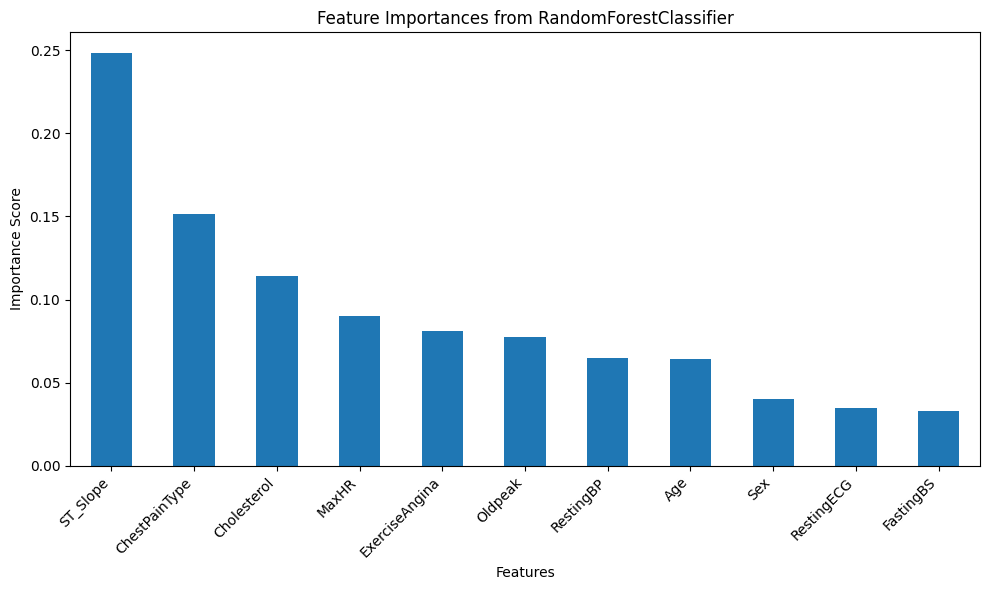

In [58]:
# 2. Model-based Feature Selection (e.g., using RandomForestClassifier)
# Using feature_importances_ attribute

print("\n--- Model-based Feature Selection (RandomForestClassifier) ---")

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_resampled, y_train_resampled)

# Get feature importances
feature_importances = pd.Series(model_rf.feature_importances_, index=X_train_resampled.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

print("\nFeature Importances (RandomForestClassifier):")
print(feature_importances_sorted)

# Select features based on importance (e.g., top k or features with importance > threshold)
# Let's select the same number of features as SelectKBest for comparison
selected_features_rf_names = feature_importances_sorted.head(k_features).index.tolist()

print(f"\nTop {k_features} features selected by RandomForestClassifier:")
print(selected_features_rf_names)

# Visualize feature importances
plt.figure(figsize=(10, 6))
feature_importances_sorted.plot(kind='bar')
plt.title('Feature Importances from RandomForestClassifier')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [59]:
chosen_features = selected_features_rf_names
print(f"\nChosen feature set for further experiments: {chosen_features}")

# Create new dataframes with only the chosen features
X_train_selected = X_train_resampled[chosen_features]
X_test_selected = X_test_processed[chosen_features] # Apply to the original test set (processed)

print("\nShape of training data with selected features:", X_train_selected.shape)
print("Shape of test data with selected features:", X_test_selected.shape)


Chosen feature set for further experiments: ['ST_Slope', 'ChestPainType', 'Cholesterol', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'RestingBP', 'Age']

Shape of training data with selected features: (14072, 8)
Shape of test data with selected features: (4328, 8)


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
# We will use the resampled data for training as an example
X_train_final = X_train_resampled
y_train_final = y_train_resampled

# And the original processed test data for evaluation
X_test_final = X_test_processed
y_test_final = y_test

# Define the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine (SVC)": SVC(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42), # Boosting Algorithm
    "AdaBoost Classifier": AdaBoostClassifier(random_state=42), # Boosting Algorithm
}

results = {}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\n--- Training and evaluating {name} ---")
    clf.fit(X_train_final, y_train_final)
    y_pred = clf.predict(X_test_final)

    accuracy = accuracy_score(y_test_final, y_pred)
    precision = precision_score(y_test_final, y_pred)
    recall = recall_score(y_test_final, y_pred)
    f1 = f1_score(y_test_final, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# Summarize results
print("\n--- Classification Results Summary ---")
results_df = pd.DataFrame(results).T
results_df


--- Training and evaluating Logistic Regression ---

--- Training and evaluating Support Vector Machine (SVC) ---

--- Training and evaluating Decision Tree ---

--- Training and evaluating Gradient Boosting Classifier ---

--- Training and evaluating AdaBoost Classifier ---


c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



--- Classification Results Summary ---


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.854205,0.940828,0.843781,0.889666
Support Vector Machine (SVC),0.932994,0.964541,0.938308,0.951244
Decision Tree,0.881238,0.944859,0.880929,0.911775
Gradient Boosting Classifier,0.921211,0.962950,0.922388,0.942233
AdaBoost Classifier,0.875693,0.941533,0.875954,0.907560



--- Performance Measures for Logistic Regression ---
Accuracy: 0.8542
Precision: 0.9408
Recall: 0.8438
F1-Score: 0.8897

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79      1313
           1       0.94      0.84      0.89      3015

    accuracy                           0.85      4328
   macro avg       0.83      0.86      0.84      4328
weighted avg       0.87      0.85      0.86      4328


Confusion Matrix:
[[1153  160]
 [ 471 2544]]


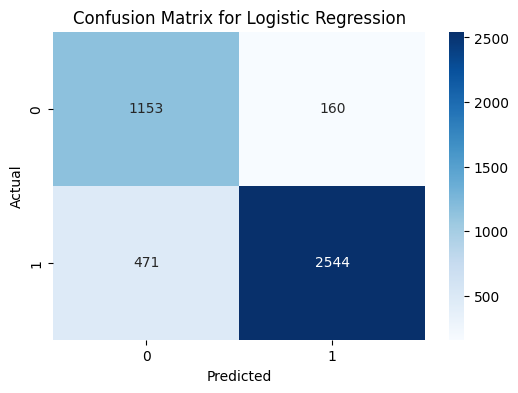


--- Performance Measures for Support Vector Machine (SVC) ---
Accuracy: 0.9330
Precision: 0.9645
Recall: 0.9383
F1-Score: 0.9512

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1313
           1       0.96      0.94      0.95      3015

    accuracy                           0.93      4328
   macro avg       0.92      0.93      0.92      4328
weighted avg       0.93      0.93      0.93      4328


Confusion Matrix:
[[1209  104]
 [ 186 2829]]


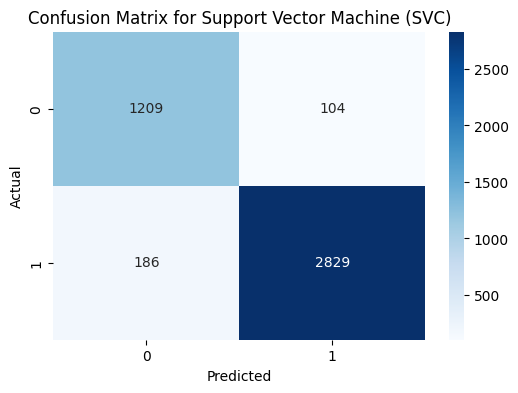


--- Performance Measures for Decision Tree ---
Accuracy: 0.8812
Precision: 0.9449
Recall: 0.8809
F1-Score: 0.9118

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1313
           1       0.94      0.88      0.91      3015

    accuracy                           0.88      4328
   macro avg       0.85      0.88      0.87      4328
weighted avg       0.89      0.88      0.88      4328


Confusion Matrix:
[[1158  155]
 [ 359 2656]]


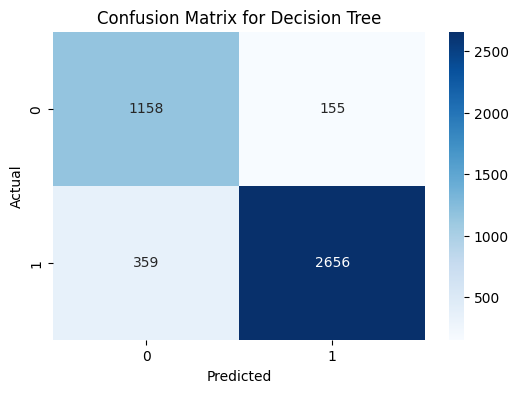


--- Performance Measures for Gradient Boosting Classifier ---
Accuracy: 0.9212
Precision: 0.9630
Recall: 0.9224
F1-Score: 0.9422

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1313
           1       0.96      0.92      0.94      3015

    accuracy                           0.92      4328
   macro avg       0.90      0.92      0.91      4328
weighted avg       0.92      0.92      0.92      4328


Confusion Matrix:
[[1206  107]
 [ 234 2781]]


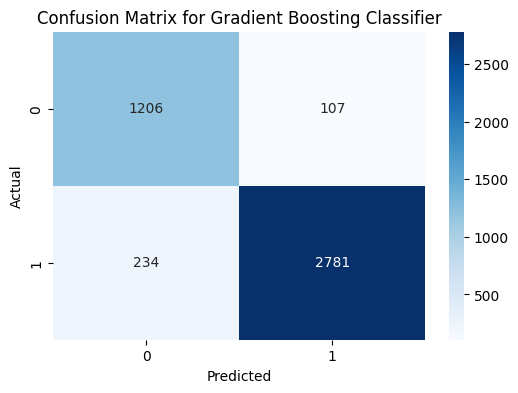


--- Performance Measures for AdaBoost Classifier ---


c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8757
Precision: 0.9415
Recall: 0.8760
F1-Score: 0.9076

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1313
           1       0.94      0.88      0.91      3015

    accuracy                           0.88      4328
   macro avg       0.85      0.88      0.86      4328
weighted avg       0.88      0.88      0.88      4328


Confusion Matrix:
[[1149  164]
 [ 374 2641]]


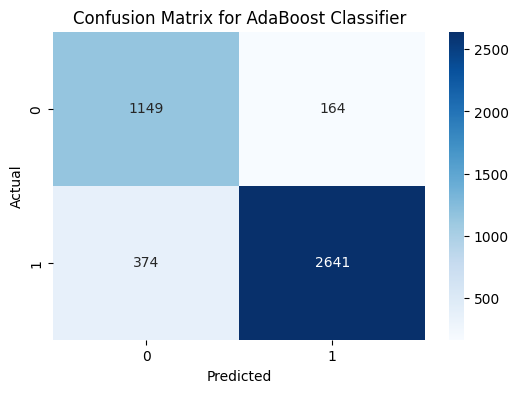


--- Classification Results Summary ---


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.854205,0.940828,0.843781,0.889666
Support Vector Machine (SVC),0.932994,0.964541,0.938308,0.951244
Decision Tree,0.881238,0.944859,0.880929,0.911775
Gradient Boosting Classifier,0.921211,0.962950,0.922388,0.942233
AdaBoost Classifier,0.875693,0.941533,0.875954,0.907560


In [61]:
# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\n--- Performance Measures for {name} ---")
    clf.fit(X_train_final, y_train_final)
    y_pred = clf.predict(X_test_final)

    # Accuracy
    accuracy = accuracy_score(y_test_final, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision
    precision = precision_score(y_test_final, y_pred)
    print(f"Precision: {precision:.4f}")

    # Recall
    recall = recall_score(y_test_final, y_pred)
    print(f"Recall: {recall:.4f}")

    # F1-Score
    f1 = f1_score(y_test_final, y_pred)
    print(f"F1-Score: {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_final, y_pred))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_final, y_pred)
    print(cm)

    # Visualize Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# Summarize results (already done in the previous chunk, but repeating for completeness)
print("\n--- Classification Results Summary ---")
results_df = pd.DataFrame(results).T
results_df

In [62]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = {}

# Use X_train_selected and y_train_resampled if you want to use selected features
for name, clf in classifiers.items():
    print(f"\n--- Cross-Validation for {name} ---")
    scores = cross_val_score(clf, X_train_selected, y_train_resampled, cv=cv, scoring='f1')
    print(f"F1-scores across folds: {scores}")
    print(f"Mean F1-score: {scores.mean():.4f}, Std: {scores.std():.4f}")
    cross_val_results[name] = {
        "F1-Mean": scores.mean(),
        "F1-Std": scores.std()
    }

# Summarize cross-validation results
print("\n--- Cross-Validation Results Summary ---")
cv_results_df = pd.DataFrame(cross_val_results).T
print(cv_results_df)


--- Cross-Validation for Logistic Regression ---
F1-scores across folds: [0.84087694 0.84444444 0.83405172 0.8455804  0.83595989]
Mean F1-score: 0.8402, Std: 0.0045

--- Cross-Validation for Support Vector Machine (SVC) ---
F1-scores across folds: [0.8773651  0.88216673 0.87535211 0.88927336 0.88567396]
Mean F1-score: 0.8820, Std: 0.0051

--- Cross-Validation for Decision Tree ---
F1-scores across folds: [0.87889518 0.86652391 0.86774431 0.87820288 0.88002848]
Mean F1-score: 0.8743, Std: 0.0059

--- Cross-Validation for Gradient Boosting Classifier ---
F1-scores across folds: [0.89396067 0.89216719 0.89852008 0.90254977 0.89929078]
Mean F1-score: 0.8973, Std: 0.0038

--- Cross-Validation for AdaBoost Classifier ---


c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

F1-scores across folds: [0.85243553 0.8703966  0.85826211 0.86907289 0.86621477]
Mean F1-score: 0.8633, Std: 0.0069

--- Cross-Validation Results Summary ---
                               F1-Mean    F1-Std
Logistic Regression           0.840183  0.004543
Support Vector Machine (SVC)  0.881966  0.005140
Decision Tree                 0.874279  0.005875
Gradient Boosting Classifier  0.897298  0.003755
AdaBoost Classifier           0.863276  0.006864


In [63]:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np

# Generate random classification data (e.g., 1000 samples, 8 features, 2 classes)
X_random, y_random = make_classification(
    n_samples=1000,
    n_features=8,
    n_informative=6,
    n_redundant=2,
    n_classes=2,
    random_state=42
)

# Convert to DataFrame for compatibility
X_random_df = pd.DataFrame(X_random, columns=[f'feature_{i+1}' for i in range(8)])
y_random_series = pd.Series(y_random, name='target')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_cv_results = {}

for name, clf in classifiers.items():
    print(f"\n--- Cross-Validation on Random Data for {name} ---")
    fold = 1
    f1_scores = []
    for train_idx, test_idx in cv.split(X_random_df, y_random_series):
        X_train, X_test = X_random_df.iloc[train_idx], X_random_df.iloc[test_idx]
        y_train, y_test = y_random_series.iloc[train_idx], y_random_series.iloc[test_idx]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)
        print(f"\nFold {fold}:")
        print(f"Train indices: {train_idx[:10]} ... (total {len(train_idx)})")
        print(f"Test indices: {test_idx[:10]} ... (total {len(test_idx)})")
        print("First 3 rows of X_train:\n", X_train.head(3))
        print("First 3 rows of X_test:\n", X_test.head(3))
        print("First 10 y_train:", y_train.head(10).values)
        print("First 10 y_test:", y_test.head(10).values)
        print(f"F1-score for this fold: {f1:.4f}")
        fold += 1
    print(f"F1-scores across folds: {f1_scores}")
    print(f"Mean F1-score: {np.mean(f1_scores):.4f}, Std: {np.std(f1_scores):.4f}")
    random_cv_results[name] = {
        "F1-Mean": np.mean(f1_scores),
        "F1-Std": np.std(f1_scores)
    }

# Summarize cross-validation results on random data
print("\n--- Cross-Validation Results Summary (Random Data) ---")
random_cv_results_df = pd.DataFrame(random_cv_results).T
print(random_cv_results_df)


--- Cross-Validation on Random Data for Logistic Regression ---

Fold 1:
Train indices: [ 0  2  3  4  5  6  7  8  9 10] ... (total 800)
Test indices: [ 1 11 15 20 25 27 32 44 47 48] ... (total 200)
First 3 rows of X_train:
    feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -1.732538   5.260112  -2.952194  -4.603768   2.235848   1.928893   
2  -0.263106   1.527781  -1.872414  -0.028009   1.612809   3.264194   
3  -0.164349  -0.550131  -0.019503  -0.765000   2.273523   2.084217   

   feature_7  feature_8  
0  -0.101845   3.193487  
2  -1.296421   1.537870  
3  -0.321931   0.426253  
First 3 rows of X_test:
     feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
1    2.072914   2.240572  -1.385104  -2.514962  -0.984756   1.436260   
11   0.995707   3.948284  -1.538950  -3.621765   0.013286   1.582491   
15  -4.021862   6.288589  -2.014751  -3.238884   1.039333   0.687733   

    feature_7  feature_8  
1   -1.255271   2.089872  
11  -1.312993   3.

c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Fold 2:
Train indices: [ 0  1  2  6  7  8  9 11 12 14] ... (total 800)
Test indices: [ 3  4  5 10 13 18 23 24 28 29] ... (total 200)
First 3 rows of X_train:
    feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -1.732538   5.260112  -2.952194  -4.603768   2.235848   1.928893   
1   2.072914   2.240572  -1.385104  -2.514962  -0.984756   1.436260   
2  -0.263106   1.527781  -1.872414  -0.028009   1.612809   3.264194   

   feature_7  feature_8  
0  -0.101845   3.193487  
1  -1.255271   2.089872  
2  -1.296421   1.537870  
First 3 rows of X_test:
    feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
3  -0.164349  -0.550131  -0.019503  -0.765000   2.273523   2.084217   
4  -1.419423   1.015324  -0.864441  -0.009297   0.385404   0.449093   
5  -0.191996   0.772984  -0.821722  -1.393938   0.801971   1.146065   

   feature_7  feature_8  
3  -0.321931   0.426253  
4  -0.029007  -1.902917  
5  -0.162120  -0.571685  
First 10 y_train: [0 0 0 1 0 0 1 0 1 

c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Fold 4:
Train indices: [ 0  1  3  4  5  6  8  9 10 11] ... (total 800)
Test indices: [ 2  7 14 17 33 35 50 52 70 72] ... (total 200)
First 3 rows of X_train:
    feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -1.732538   5.260112  -2.952194  -4.603768   2.235848   1.928893   
1   2.072914   2.240572  -1.385104  -2.514962  -0.984756   1.436260   
3  -0.164349  -0.550131  -0.019503  -0.765000   2.273523   2.084217   

   feature_7  feature_8  
0  -0.101845   3.193487  
1  -1.255271   2.089872  
3  -0.321931   0.426253  
First 3 rows of X_test:
     feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
2   -0.263106   1.527781  -1.872414  -0.028009   1.612809   3.264194   
7    1.105202  -0.826817  -2.637116   0.426077   3.001094   6.750346   
14  -4.167167   5.068383  -1.444200  -1.524386   0.147588  -0.199195   

    feature_7  feature_8  
2   -1.296421   1.537870  
7   -2.176442  -1.178026  
14  -0.545036  -3.098555  
First 10 y_train: [0 0 0 1 1 

c:\Users\Muzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [64]:
import joblib
import os

# Create a directory for models if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save each trained model
joblib.dump(classifiers["Logistic Regression"], "models/logistic_regression.pkl")
joblib.dump(classifiers["Support Vector Machine (SVC)"], "models/svc.pkl")
joblib.dump(classifiers["Decision Tree"], "models/decision_tree.pkl")
joblib.dump(classifiers["Gradient Boosting Classifier"], "models/gradient_boosting.pkl")
joblib.dump(classifiers["AdaBoost Classifier"], "models/adaboost.pkl")

print("Models saved in the 'models' directory.")

# To download in Jupyter, you can use:
from IPython.display import FileLink, display

for model_file in [
    "models/logistic_regression.pkl",
    "models/svc.pkl",
    "models/decision_tree.pkl",
    "models/gradient_boosting.pkl",
    "models/adaboost.pkl"
]:
    display(FileLink(model_file))

Models saved in the 'models' directory.


c:\Users\Muzam\OneDrive\Desktop\MLProject\DS1\models\logistic_regression.pkl

c:\Users\Muzam\OneDrive\Desktop\MLProject\DS1\models\svc.pkl

c:\Users\Muzam\OneDrive\Desktop\MLProject\DS1\models\decision_tree.pkl

c:\Users\Muzam\OneDrive\Desktop\MLProject\DS1\models\gradient_boosting.pkl

c:\Users\Muzam\OneDrive\Desktop\MLProject\DS1\models\adaboost.pkl